## MATH 6373 Final Project
## Atanga Cynthia
## May 06, 2020

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){

$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the
raw code."></form>''')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from sklearn.model_selection import train_test_split
from numpy import linalg as LA
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
import math
import random
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1) & 2a) Importing data set 


This data set consists of the closing stock prices of the S&P 500 stock market from January 2014 to December 2017. The data set has 1007 cases and one column, which will later be expanded into a line vector that will be used to predict the closing stock prices a day ahead S(t+1), where t represents day t. The initial data set is shown below.

In [4]:
stocks=['SNP']
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2017,12,31)
data = yf.download(stocks, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [5]:
#dataframe
data=data['Close']
data

Date
2014-01-02    79.930000
2014-01-03    78.669998
2014-01-06    77.239998
2014-01-07    77.000000
2014-01-08    76.230003
                ...    
2017-12-22    73.430000
2017-12-26    74.059998
2017-12-27    73.870003
2017-12-28    73.300003
2017-12-29    73.370003
Name: Close, Length: 1007, dtype: float64

### 2b) Data preprocessing

 The data is checked to ensure that there are no null values so that preprocessing is done without adequately.

In [6]:
data[data.isnull()].sum()

0.0

There are currently no null values in the data. 

The moving averages MA5t, MA10t, MA20t are computed using the formulas:

MA5(t) = [S(t-4) + S(t-3) + S(t-2) +S(t-1) + S(t) ] /5

MA10(t) = [S(t-9) + S(t-8) + ... + S(t) ] /10

MA20(t) = [S(t-19) + S(t-18) + ... + S(t) ] /20

A plot of these moving averages, along with St is shown below. Here we can see that the moving averages coherently fluctuate along with the original values throughout the timeline. The plots show an overall drop in stock price from the start of the 4 years till the end, with 2 peaks and a major drop in the first half.This could be indicative of an overall stock market change with other stocks or perhaps it had to do with the country's economy at the time. These are instances that could be recognized by our predictor and can result in predictions of possible rise and drops in our predicted results of the future stock prices. 
The moving averages and St will now be used to expand our data set.

Text(0.5, 1.0, 'Plot of St and moving averages')

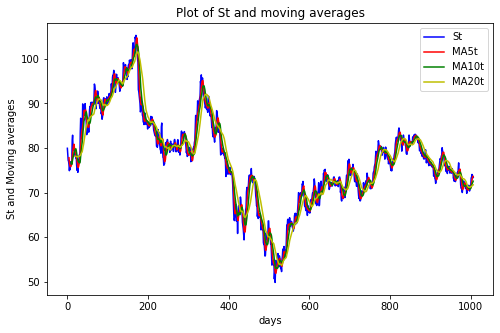

In [7]:
MA5t=data.iloc[:,].rolling(window=5).mean()
MA10t=data.iloc[:,].rolling(window=10).mean()
MA20t=data.iloc[:,].rolling(window=20).mean()
#plot St, MA5t, MA10t, MA20t
labels=['St','MA5t','MA10t','MA20t']
%matplotlib inline
plt.figure(figsize=(8, 5))
fig=plt.figure(1)
plt.plot(data.values, color='b')
plt.plot(MA5t.values, color='r')
plt.plot(MA10t.values, color='g')
plt.plot(MA20t.values, color='y')
plt.legend(labels)
plt.ylabel('St and Moving averages')
plt.xlabel('days')
plt.title('Plot of St and moving averages')

### 3) Training and Test sets for MLP Predictor

In [0]:
#define function to create 1x18 line vector

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('S%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('S%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('S%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [0]:
#convert all data to data frames
data=pd.DataFrame(data)
MA5t=pd.DataFrame(MA5t)
MA10t=pd.DataFrame(MA10t)
MA20t=pd.DataFrame(MA20t)

Using a user-defined functioned, the data set is expanded into line vectors of the series S(t+1) recent past, [S(t),S(t-1),S(t-2),...S(t-19)].

In [10]:
#creating line vector from previously defined series+to_supervised function
data_1=series_to_supervised(data, 19, 2)
round(data_1.head(),2)

,S1(t-19),S1(t-18),S1(t-17),S1(t-16),S1(t-15),S1(t-14),S1(t-13),S1(t-12),S1(t-11),S1(t-10),S1(t-9),S1(t-8),S1(t-7),S1(t-6),S1(t-5),S1(t-4),S1(t-3),S1(t-2),S1(t-1),S1(t),S1(t+1)
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-30,79.93,78.67,77.24,77.00,76.23,74.90,75.80,75.19,76.88,76.62,76.27,77.23,81.80,82.87,80.31,79.47,79.87,79.99,78.27,79.05,78.83
2014-01-31,78.67,77.24,77.00,76.23,74.90,75.80,75.19,76.88,76.62,76.27,77.23,81.80,82.87,80.31,79.47,79.87,79.99,78.27,79.05,78.83,77.76
2014-02-03,77.24,77.00,76.23,74.90,75.80,75.19,76.88,76.62,76.27,77.23,81.80,82.87,80.31,79.47,79.87,79.99,78.27,79.05,78.83,77.76,78.18
2014-02-04,77.00,76.23,74.90,75.80,75.19,76.88,76.62,76.27,77.23,81.80,82.87,80.31,79.47,79.87,79.99,78.27,79.05,78.83,77.76,78.18,76.07
2014-02-05,76.23,74.90,75.80,75.19,76.88,76.62,76.27,77.23,81.80,82.87,80.31,79.47,79.87,79.99,78.27,79.05,78.83,77.76,78.18,76.07,74.98


In [0]:
#extract all data from day t>=20
MA5t_1=MA5t.iloc[19:1006]
MA5t_1=MA5t_1.rename(columns={"Close": "MA5t"})
MA10t_1=MA10t.iloc[19:1006]
MA10t_1=MA10t_1.rename(columns={"Close": "MA10t"})
MA20t_1=MA20t.iloc[19:1006]
MA20t_1=MA20t_1.rename(columns={"Close": "MA20t"})
data_2=data_1.iloc[:,5:]

The series St is then combined with the moving averages series to form a 987x18 data set, Vt, where Vt will be the input vector into neural network MLP predictor. This MLP will be used to compute on day t, the TARGt = S(t+1), which is unknown at time t.

In [12]:
#combine line vector with moving averages
df=pd.concat([MA5t_1,MA10t_1,MA20t_1,data_2],axis=1)
Y=df.iloc[:,-1]
Vt=df.iloc[:,:18]
print('Dimension of Vt:', Vt.shape,'\n')
round(Vt.head(),2)

Dimension of Vt: (987, 18) 



,MA5t,MA10t,MA20t,S1(t-14),S1(t-13),S1(t-12),S1(t-11),S1(t-10),S1(t-9),S1(t-8),S1(t-7),S1(t-6),S1(t-5),S1(t-4),S1(t-3),S1(t-2),S1(t-1),S1(t)
Date,,,,,,,,,,,,,,,,,,
2014-01-30,79.33,79.51,78.18,74.90,75.80,75.19,76.88,76.62,76.27,77.23,81.80,82.87,80.31,79.47,79.87,79.99,78.27,79.05
2014-01-31,79.20,79.77,78.12,75.80,75.19,76.88,76.62,76.27,77.23,81.80,82.87,80.31,79.47,79.87,79.99,78.27,79.05,78.83
2014-02-03,78.78,79.82,78.08,75.19,76.88,76.62,76.27,77.23,81.80,82.87,80.31,79.47,79.87,79.99,78.27,79.05,78.83,77.76
2014-02-04,78.42,79.46,78.13,76.88,76.62,76.27,77.23,81.80,82.87,80.31,79.47,79.87,79.99,78.27,79.05,78.83,77.76,78.18
2014-02-05,77.98,78.78,78.08,76.62,76.27,77.23,81.80,82.87,80.31,79.47,79.87,79.99,78.27,79.05,78.83,77.76,78.18,76.07


In [13]:
#randomly split set of predcases into train and test
x_train, x_test, y_train, y_test = train_test_split(Vt, Y, test_size=0.1, random_state=1)
print('Dimension of train and test from random split, using train size=90% and random state=1','\n')

#get indices
train_index=y_train.index
test_index=y_test.index

x_train.shape, x_test.shape


Dimension of train and test from random split, using train size=90% and random state=1 



((888, 18), (99, 18))

### 4) MLP predictor : Our MLP predictor (MLPpred) will have the simple 3 layers architecture
INPUT ==> HiddenLayer K ==> OUTPUT with dim(INPUT) = 18 , dim(OUTPUT) = 1

#### PCA analysis to determine dim(k)=k

All eigen values; 18




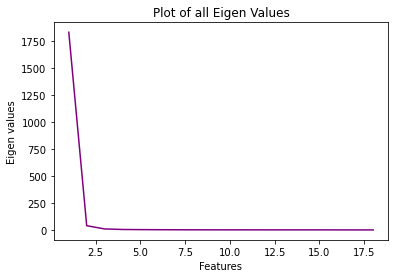

In [14]:
pca1=PCA(18)
pca1.fit(x_train)
h100=pca1.n_components_
print('All eigen values;',h100)
vals1=pca1.explained_variance_ #get eigen values
Lj=vals1.tolist()
j=list(range(1,len(Lj)+1))
plt.plot(j,Lj,c='purple')
plt.title('Plot of all Eigen Values')
plt.xlabel('Features')
plt.ylabel('Eigen values')
print('\n')

Text(0.5, 0, 'Features')

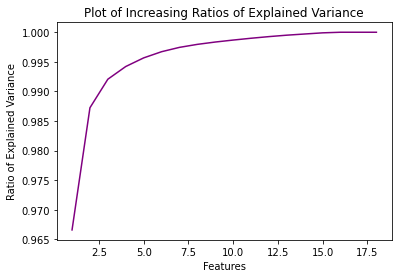

In [15]:
x=pd.DataFrame(Lj).cumsum()
RATj=x/sum(Lj)
plt.plot(j,RATj,c='purple')
plt.title('Plot of Increasing Ratios of Explained Variance')
plt.ylabel('Ratio of Explained Variance')
plt.xlabel('Features')

Number of components, h95: 1
eigen values from x_train: 
 [1828.32]


Text(0.5, 1.0, 'Plot of x_train Eigen Values for 95% explained variance')

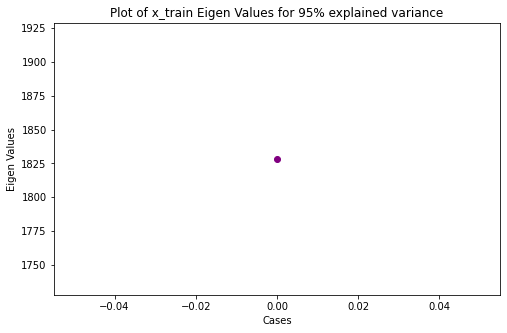

In [24]:
pca=PCA(0.95)
pca.fit(x_train)
h95=pca.n_components_
print('Number of components, h95:',h95)
eigval_train=pca.explained_variance_ #get eigen values
round_eig=[round(num, 2) for num in eigval_train]
print('eigen values from x_train:','\n',round_eig)
#plot eigen values
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.figure(1)
plt.plot(eigval_train,  marker='o', label='Eigen Values', color='purple')
plt.ylabel('Eigen Values')
plt.xlabel('Cases')
plt.title('Plot of x_train Eigen Values for 95% explained variance')

Running a PCA analysis with 95% explained variance yields a value h95 = 1. This is a considerably low result as having the dim(k) = 1 could likely produce poor results from the MLP predictor. Although it has previously been said that the "effect of h is highly non-linear", a dimension of 1 is not a reasonable value for an autoencoder. Hence, we will attempt to find dim(k) using 99% explained variance.

Number of components, h99: 3
eigen values from x_train: 
 [1828.32, 39.06, 9.12]


Text(0.5, 1.0, 'Plot of x_train Eigen Values for 99% explained variance')

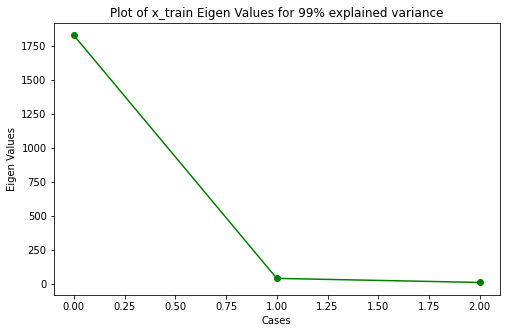

In [25]:
pca=PCA(0.99)
pca.fit(x_train)
h99=pca.n_components_
print('Number of components, h99:',h99)
eigval_train=pca.explained_variance_ #get eigen values
round_eig=[round(num, 2) for num in eigval_train]
print('eigen values from x_train:','\n',round_eig)
k=h99
#plot eigen values
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.figure(1)
plt.plot(eigval_train,  marker='o', label='Eigen Values', color='g')
plt.ylabel('Eigen Values')
plt.xlabel('Cases')
plt.title('Plot of x_train Eigen Values for 99% explained variance')

In running the PCA using 99% explained variance, we are able to achieve a dim(k) = 3. This is a reasonable result and will hence be used to train an MLP used for prediction.

### Compute the number w of weights and thresholds in this MLP, and compare w to the number of informations provided by the training set.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras import optimizers, losses
from tensorflow.keras import callbacks
from numpy.random import seed
from tensorflow.python.framework import ops

In [163]:
#begin building of mlp to extract weights
os.environ['PYTHONHASHSEED']=str(1)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # new flag present in tf 2.0+
np.random.seed(123)
tf.random.set_seed(123)
ops.reset_default_graph()
mlp = Sequential()
mlp.add(Dense(k, activation='relu', input_dim=18, bias_initializer=Constant(value=5)))
mlp.add(Dense(1, activation='relu', bias_initializer=Constant(value=5)))
mlp.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 57        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


There are a total of 57 paramaters linking the input neurons to the hidden layer of dimension k=3; 54 weights which is defined by an 18x3 vector, and 3 thresholds. There are 4 parameters linking the neurons in the hidden layer to the OUT layer; a 1x3 weight vector and 1 threshold.

Simply put:

INP => H :  18x3 weights + 3 thresholds

H => OUT :  1x3 weights + 1 threshold

Total number of weights & thresholds, w is 61. The training set size is 888 cases with 18 features. Each training case yields 1 constraint which represents the  true output of the prediction computation.The robustness ratio of these numbers is given by;

robustness ratio = (# constraints)/(# unknowns) 

This value in our case is (888x1)/61  = 14.56

This interprets as approximately 14.56 infos per unknown which is a "reasonable" robustness. 
The robustness ratio typically should be as high as possible in order for the learning process to be as very successful. One suggestion to increase this ratio is by increasing the training set size, perhaps by a factor of 10. This will increase the robustness ratio to about 145 which is a very descent value.


In [0]:
#extract weight and biases from mlp
W1=mlp.layers[0].get_weights()[0]
b1=mlp.layers[0].get_weights()[1]
W2=mlp.layers[1].get_weights()[0]
b2=mlp.layers[1].get_weights()[1]

### 5) Training of the MLP predictor: Implement an automatic training on the training set PredTRAIN

Initial MLP training choice of hyperparameters

***
Response function: Relu

loss function: Mean Squared Error
***
Optimizer: ADAM

Learning rate: 0.01

beta_1 - The exponential decay rate for the first moment estimates: 0.9 

beta_2 - The exponential decay rate for the second-moment estimates: 0.99
***
Training Epochs: 1000

Batch size: 100
***

In [0]:
#reshape dataframes
x_train=pd.DataFrame(x_train).values.reshape(888,18)
x_test=pd.DataFrame(x_test).values.reshape(99,18)
y_train=pd.DataFrame(y_train).values.reshape(888,1)
y_test=pd.DataFrame(y_test).values.reshape(99,1)

In [0]:
start = time.process_time()
# configure suitable lr and decay
mlp.compile(optimizer=optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99, amsgrad=False), loss='mean_squared_error')
#mlp.compile(optimizer=optimizers.SGD(learning_rate=0.01, decay=1e-7), loss='mean_squared_error')
class mlpMyHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
      self.MSEtrain = []
      self.MSEtest = []
    def on_batch_end(self, batch, logs={}):
      self.MSEtrain.append(self.model.evaluate(x_train,y_train,verbose = 0))
      self.MSEtest.append(self.model.evaluate(x_test,y_test,verbose = 0))

mlpMyMonitor = mlpMyHistory()

es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200, restore_best_weights=True)
mlpMonitor = mlp.fit(x_train, y_train, epochs=1000, batch_size=100, callbacks = [mlpMyMonitor, es], validation_data = (x_test, y_test), verbose = 2)
print('Computation time for MLP training:',time.process_time() - start)

Text(0.5, 1.0, 'Plot of MSEtrain and MSEtest from MLP')

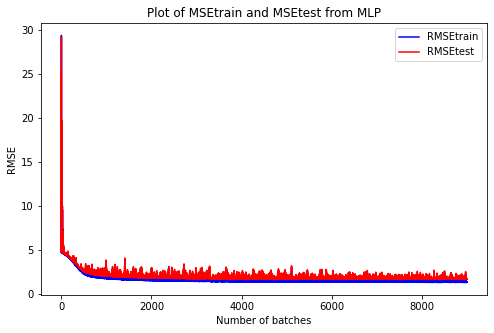

In [206]:
#plot RMSE
labels=['RMSEtrain','RMSEtest']
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.figure(1)
plt.plot(np.sqrt(mlpMyMonitor.MSEtrain),label='RMSEtrain', color='b')
plt.plot(np.sqrt(mlpMyMonitor.MSEtest),label='RMSEtest', color='r')
plt.legend(labels)
plt.ylabel('RMSE')
plt.xlabel('Number of batches')
plt.title('Plot of MSEtrain and MSEtest from MLP')

Text(0.5, 1.0, 'Zoomed in Plot of MSEtrain and MSEtest from MLP')

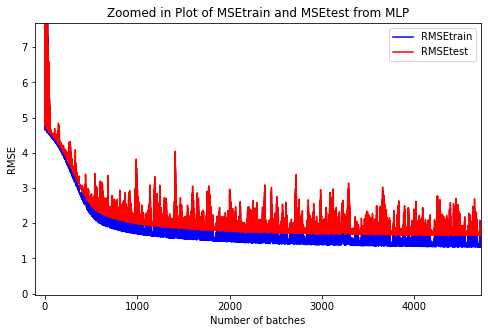

In [228]:
#plot RMSE
labels=['RMSEtrain','RMSEtest']
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.figure(1)
plt.plot(np.sqrt(mlpMyMonitor.MSEtrain),label='RMSEtrain', color='b')
plt.plot(np.sqrt(mlpMyMonitor.MSEtest),label='RMSEtest', color='r')
scale_factor = 4
scale=2
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.xlim(xmin/scale_factor, xmax/scale)
plt.ylim(ymin/scale_factor, ymax/scale_factor)
plt.legend(labels)
plt.ylabel('RMSE')
plt.xlabel('Number of batches')
plt.title('Zoomed in Plot of MSEtrain and MSEtest from MLP')

The plots of RMSEtrain and RMSE test decay abruptly until a value below 5, and then gradually decrease to near zero as the number of batches increase. The graphs mimic one another with the RMSEtest slightly greater than the RMSEtrain. The closeness in the graphs is indicative that the MLP is doing a fairly good job in the learning and generalizing of the data. The RMSEtest plot being higher is expected as this is the error from computation on new data not seen and can only perform so well, as opposed to the training set whose data has already been learnt by the predictor. Despite the fact that the MLP does a good job in learning and generalizing data, it did not perform well on the aspect of minimizing the overall RMSE values for both train and test. The expectation is to minimize error as much as possible, closest to zero. While this is not the case, it may be an indication of the need to tune the hyperparameters to find the optimal set that will minimize error the most. 

The computation time used to train the MLP was approximately 13 minutes. This rather too long for a data set of size 1007 cases. As we know, computation time could increase aggressively with an increase in data set size which is not good. The time here was seen to vary with choice of epoch number and batch size, because these greatly affect the number of iterations done in the training. A larger epoch number and smaller batch size increases computation time, while increasing batch size and decreasing epoch number decreases computation time. This is however a slight dilemma because the MLP seems to work best with larger epoch number and small batch size since more iterations could improve robustness dramatically. 

Text(0.5, 1.0, 'Plot of TARGt_test and Zt_test from MLP')

<Figure size 432x288 with 0 Axes>

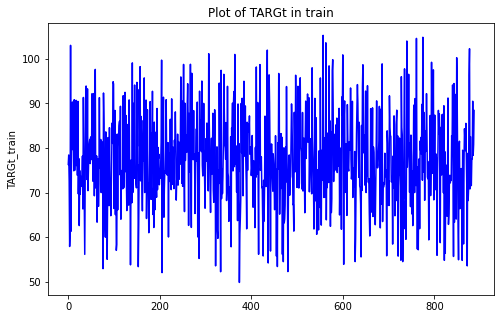

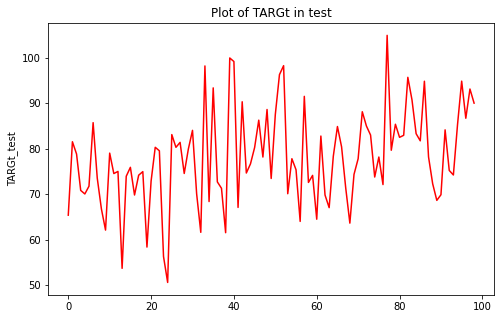

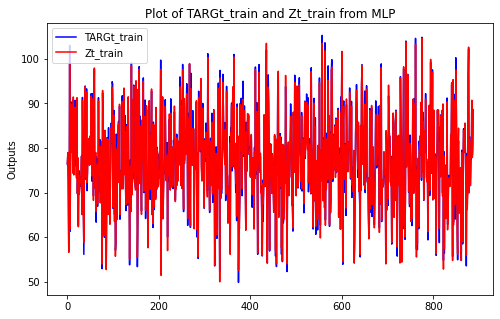

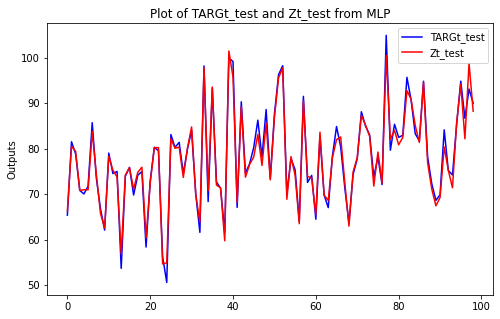

In [169]:
z_train=mlp.predict(x_train)
z_test=mlp.predict(x_test)

#plot TARGt vs Zt
labels1=['TARGt_train','Zt_train']
labels2=['TARGt_test','Zt_test']

%matplotlib inline
plt.figure(2)
plt.figure(figsize=(8, 5))
plt.plot(y_train, color='b')
plt.ylabel('TARGt_train')
plt.title('Plot of TARGt in train')

plt.figure(3)
plt.figure(figsize=(8, 5))
plt.plot(y_test, color='r')
plt.ylabel('TARGt_test')
plt.title('Plot of TARGt in test')

plt.figure(4)
plt.figure(figsize=(8, 5))
plt.plot(y_train, color='b')
plt.plot(z_train, color='r')
plt.legend(labels1)
plt.ylabel('Outputs')
plt.title('Plot of TARGt_train and Zt_train from MLP')

plt.figure(5)
plt.figure(figsize=(8, 5))
plt.plot(y_test, color='b')
plt.plot(z_test, color='r')
plt.legend(labels2)
plt.ylabel('Outputs')
plt.title('Plot of TARGt_test and Zt_test from MLP')


The plots of TARDt_train and TARGt_test are initially shown to give a general perspective of what the stock prices are in out target feature. It is notable that the stock prices in train seem to fluctuate aggressively about the same range of values, betwwen approximately 50 and 100. The values in the test fluctuate as well but they however show a slight increase overall over the 4 years period.

When our predictions (Zt_train and Zt_test) are plotted against train and test on a general overview scale, we see that the results are very much centered along our target stock prices with slight outliers. This is an indication that the MLP predictor might have done a reasonable job in predicting out results. 

Although the plots may look good from a general perspective, it is important to take a closer look at how each line varies with the other to see how well the predictions were made. This needs to be done through a zoomed in plot, that shows results over a few number of successive days. A closer look at the plots using 8 successive days is shown below.

DatetimeIndex(['2016-05-16', '2017-03-21', '2014-02-27', '2016-04-07',
               '2014-11-24', '2016-02-25', '2015-12-07', '2015-02-13'],
              dtype='datetime64[ns]', name='Date', freq=None)

<Figure size 432x288 with 0 Axes>

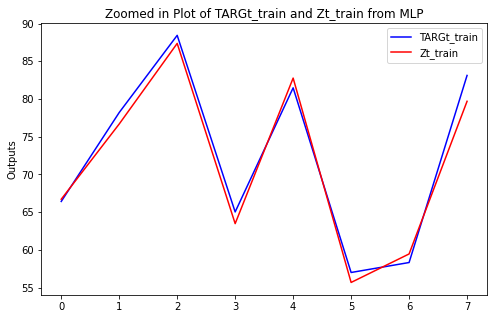

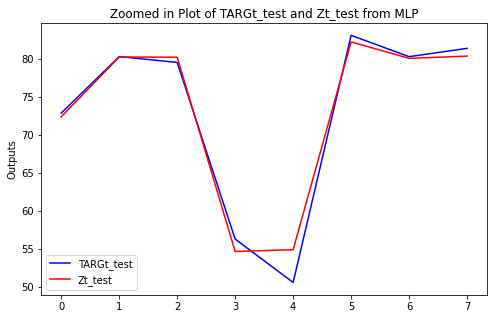

In [170]:
%matplotlib inline
plt.figure(6)
plt.figure(figsize=(8, 5))
plt.plot(y_train[100:108], color='b')
plt.plot(z_train[100:108], color='r')
#plt.xticks(train_index[100:108])
plt.legend(labels1)
plt.ylabel('Outputs')
plt.title('Zoomed in Plot of TARGt_train and Zt_train from MLP')


plt.figure(7)
plt.figure(figsize=(8, 5))
plt.plot(y_test[20:28], color='b')
plt.plot(z_test[20:28], color='r')
#plt.xticks(test_index[20:28])
plt.legend(labels2)
plt.ylabel('Outputs')
plt.title('Zoomed in Plot of TARGt_test and Zt_test from MLP')
train_index[100:108]

From the zoomed in plots, we can now have a clearer visual of poth target and predicted lines. For both train and test plots, the target seems to have captured the direction in our data. However, these pictures show the errors are slightly bigger than when viewed on the larger scale. We can still agree that the MREP did reasonably well in predicting the results but the failure to do so more precisely. This could be lead to slightly erroneous predictions in the future for new data not seen. 

In [171]:
MREPtrain=np.average(abs(z_train-y_train)/y_train)
MREPtest=np.average(abs(z_test-y_test)/y_test)
print('MREPtrain:',round(MREPtrain,3))
print('MREPtest:',round(MREPtest,3))

MREPtrain: 0.013
MREPtest: 0.016


The mean relative errors of prediction (MREP) on train and test are respectively 0.013 (1.3%) and 0.016 (1.6%) respectively. This tells us that an average error of prediction for every new stock case is 1.6%. These values agree with the graphs above that show firstly, that RMSE of train was overall better (lower) than RMSE of test which means there is not an instance of overfitting. Secondly, the test results are very close to the train results, differing in MREP by 0.003 which is not bad and it shows that our MLP has done well in generalizing using the training set.Thirdly, the MLP did well in mimicking the target values but still faced the problem of some erroneous results. An MREP OF 1.6% is not bad but is seemingly still not great. The goal is to get as close to 0 as possible in order to completely minimize the possibility of making a false prediction on our data set. 

Having a low accuracy (high error of prediction) could greatly impact the accuracy of future predictions which can be hurtful to people who utilize the stock price predictions to make business decisions. In this case, there is a tendency to underestimate more often than overestimate due to uncertainty in the results. Practically, this could impact a simple betting strategy as a risk is being taken and can turn out to be either greater or lesser than the expected outcome. Losses or gains could be made and the confidence in the outcome of our predictions will be lessened. Looking at it from a general business perspective points out the importance in improving the robustness of our MLP predictor. Possible ways to improve the robustness may be by increasing the value of k for our hidden layers, or repeating the MLP training testing with other randomly chosen test sets of same size.

### 6) Denote NOD1 NOD2 ... NODk the hidden neurons . For j= 1...k, compute and display the mean activity Yj of NODj over all cases in the Training set. Display all the weights W1 ... Wk linking the neurons NOD1 ... NODk to the output node.

In [0]:
#extract weight and biases
W1=mlp.layers[0].get_weights()[0]
b1=mlp.layers[0].get_weights()[1]
W2=mlp.layers[1].get_weights()[0]
b2=mlp.layers[1].get_weights()[1]

In [0]:
#Global states of hidden layers
hidden_global_states=[]
for i in range(len(x_train)):
    matrix=np.reshape(W1,(18,k))
    case=np.array([x_train[i]])
    state=pd.DataFrame(np.matmul(case,matrix)+np.matrix(b1))
    hidden_global_states.append(state)
a=pd.concat(hidden_global_states)

#### Activity vectors of hidden neurons:


In [182]:
#hidden layer activity vectors
neuron_states=pd.concat(hidden_global_states).reset_index(drop=True)
round(neuron_states,2)

,0,1,2
0,-221.01,1.87,159.20
1,-243.46,9.35,171.50
2,-217.10,10.70,156.82
3,-167.77,6.44,120.68
4,-184.99,1.35,130.59
...,...,...,...
883,-241.35,9.71,170.94
884,-274.48,6.76,194.20
885,-230.46,6.18,166.12
886,-239.10,11.22,172.94


#### Mean activity of hidden neurons

In [175]:
#mean of activity vectors
Actj=round(neuron_states.mean(axis=0),2)
Actj=np.asarray(Actj)
Actj=np.reshape(Actj,(3,1))
Actj

array([[-233.97],
       [   8.83],
       [ 166.97]])

#### Weights linking neurons to output node

In [176]:
#display weights
W2=np.round(W2,2)
W2

array([[ 0.95],
       [-0.44],
       [ 0.47]], dtype=float32)

#### For each hidden NODj compute IMPj = Wj Yj = average impact of NODj on the prediction Zt.

In [177]:
# Computing IMPj
IMPj = np.round(W2*Actj,2)
print('Average impact of NODj on prediction Zt, IMPj','\n',IMPj)

Average impact of NODj on prediction Zt, IMPj 
 [[-222.27]
 [  -3.89]
 [  78.48]]


The hidden neuron NOD* with maximal impact on Zt is NOD1 = -222.27

### 7) Denote INP1 INP2 ... INP18 the 18 input neurons. Compute and display the mean activities X1 ... X18 of the 18 input neurons. Display all the weights U1 ... U18 linking the input nodes INP1 ... INP18 to the neuron NOD*.

#### Mean activities of 18 input neurons

In [178]:
Act2=np.round(x_train.mean(axis=0),2)
Act2

array([77.34, 77.37, 77.42, 77.48, 77.47, 77.46, 77.46, 77.44, 77.43,
       77.42, 77.41, 77.4 , 77.37, 77.34, 77.33, 77.33, 77.35, 77.33])

#### Weights linking input nodes to the neuron NOD* =  NOD1. Below is the weight vector with the 1st column showing the weight that directly links to NOD1

In [179]:
np.round(W1,2)

array([[-0.4 , -0.18, -0.05],
       [ 0.05,  0.13,  0.33],
       [-0.21, -0.07,  0.12],
       [-0.41, -0.19, -0.32],
       [-0.29,  0.11,  0.21],
       [-0.23,  0.08,  0.  ],
       [-0.06,  0.07,  0.15],
       [ 0.42,  0.06, -0.01],
       [-0.02,  0.31,  0.19],
       [-0.01,  0.09,  0.18],
       [-0.21,  0.31,  0.19],
       [-0.16,  0.23,  0.21],
       [ 0.33, -0.12, -0.23],
       [-0.02, -0.41, -0.21],
       [-0.53,  0.42,  0.09],
       [-0.37,  0.16,  0.37],
       [-0.53, -0.26, -0.08],
       [-0.44, -0.74,  0.96]], dtype=float32)

Computing INPs; Fs=UsXs, average impact of feature 's' on key hidden neuron NOD*=NOD3

In [181]:
Fs=np.round(W1[:,0]*Act2,2)
Fs=pd.DataFrame(Fs)
Fs=Fs.rename(columns={0: 'Feature IMP'})
print('Average impact of 18 input features, Fs','\n','\n',Fs,'\n')

print('Top 5 input features with larest impact on NOD* =NOD3')
F_top=Fs.sort_values(by='Feature IMP')
F_top[:5]

Average impact of 18 input features, Fs 
 
     Feature IMP
0        -30.91
1          3.82
2        -15.92
3        -31.39
4        -22.61
5        -17.71
6         -4.95
7         32.90
8         -1.33
9         -0.80
10       -16.20
11       -12.51
12        25.17
13        -1.20
14       -41.07
15       -28.70
16       -41.28
17       -34.27 

Top 5 input features with larest impact on NOD* =NOD3


,Feature IMP
16,-41.28
14,-41.07
17,-34.27
3,-31.39
0,-30.91


From our analysis, the NOD1 has shown to have the largest impact on making predictions Zt. The features that have the largest impact here are feature 16, 14, 17, 3,  and 0. This means that days t-16, t-14, t-17, t-3, and t make the most impact on the largest neuron activity and consequently, the most impact on prediction of Zt. Not to say that the other features performed poorly, but there is a possibility of some input neurons posing as 'lazy neurons' that do not make much impact at all in NOD3. It is also possible that because they are inactive in NOD3, they are possibly more active in either of the other 2 NODs. An example here is feature 9 and feature 13. Another remark is the fact that majority of the features turned out to have -ve activity. This is definitely something to look into, to see how this plays into our results.

### Tuning of MLP to produce optimal results and improve robustness

The first method used will be to use different train and test cases of the same size. Initially this was picked by setting the random_state = 1 , in the train-test-split segment. We will try random_states = [1,10,50] and see how our RMSE and MREP are being affected.

Next we will search for an optimal value of k in range 1<=k<=18. Our values of h tested will be k=[3,5,9]

This will be followed by picking various seed values for the random initialization of weights and biases. The seed value typically ensures reproducability of the same set of randomized weights and biases. If the seed value is changed, a different set of randomized weights and biases is produced. In this case, we would like to verify what the optimal seed value for the initialization of weights and biases is close to.


1) Using varying random states (R_S) to generate new train and test cases from data split.

In [0]:
start = time.process_time()
random_state=[1,10,50]

def mlp_out(R_S):
  #randomly split set of predcases into train and test
  x_train1, x_test1, y_train1, y_test1 = train_test_split(Vt, Y, test_size=0.1, random_state=R_S)
  print('Dimension of train and test from random split, using train size=90% and random state=','\n')
  print(x_train1.shape,x_test1.shape)

  #begin building of mlp to extract weights
  os.environ['PYTHONHASHSEED']=str(1)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # new flag present in tf 2.0+
  np.random.seed(123)
  tf.random.set_seed(123)
  ops.reset_default_graph()
  mlp = Sequential()
  mlp.add(Dense(k1, activation='relu', input_dim=18, bias_initializer=Constant(value=5)))
  mlp.add(Dense(1, activation='relu', bias_initializer=Constant(value=5)))
  mlp.summary()

  #reshape dataframes
  x_train1=pd.DataFrame(x_train1).values.reshape(888,18)
  x_test1=pd.DataFrame(x_test1).values.reshape(99,18)
  y_train1=pd.DataFrame(y_train1).values.reshape(888,1)
  y_test1=pd.DataFrame(y_test1).values.reshape(99,1)

  # configure suitable lr and decay
  mlp.compile(optimizer=optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99, amsgrad=False), loss='mean_squared_error')
  #mlp.compile(optimizer=optimizers.SGD(learning_rate=0.01, decay=1e-7), loss='mean_squared_error')
  class mlpMyHistory(callbacks.Callback):
      def on_train_begin(self, logs={}):
        self.MSEtrain1 = []
        self.MSEtest1 = []
      def on_batch_end(self, batch, logs={}):
        self.MSEtrain1.append(self.model.evaluate(x_train1,y_train1,verbose = 0))
        self.MSEtest1.append(self.model.evaluate(x_test1,y_test1,verbose = 0))

  mlpMyMonitor1 = mlpMyHistory()

  es1 = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200, restore_best_weights=True)
  mlpMonitor1 = mlp.fit(x_train1, y_train1, epochs=1000, batch_size=100, callbacks = [mlpMyMonitor1, es1], validation_data = (x_test1, y_test1), verbose = 2)
  z_train1=mlp.predict(x_train1)
  z_test1=mlp.predict(x_test1)
  MREPtrain1=np.average(abs(z_train1-y_train1)/y_train1)
  MREPtest1=np.average(abs(z_test1-y_test1)/y_test1)
  MSE_train1=mlpMyMonitor1.MSEtrain1
  
  return MSE_train1, MREPtrain1, MREPtest1

%matplotlib inline
plt.figure(figsize=(8, 5))
plt.figure(8)
labels3=['R_S=1','R_S=10','R_S=50']
for R_S in random_state:
  MSE_train1, MREPtrain1, MREPtest1 = mlp_out(R_S)
  plt.plot(np.sqrt(MSE_train1))
  print('R_S=', R_S,'MREPtrain:',round(MREPtrain1,3))
  print('MREPtest:',round(MREPtest1,3))
  scale_factor = 3
  scale=2
  xmin, xmax = plt.xlim()
  ymin, ymax = plt.ylim()
  plt.xlim(xmin/scale_factor, xmax/scale)
  plt.ylim(ymin/scale_factor, ymax/scale_factor)
plt.xlabel('Number of batches')
plt.legend(labels3)
plt.title('Zoomed in Plot of RMSE_train from MLP with varing train-test cases of same size')
plt.show()
comp_time=time.process_time() - start
print('Computation time for MLP training:',round(comp_time,2),'seconds')


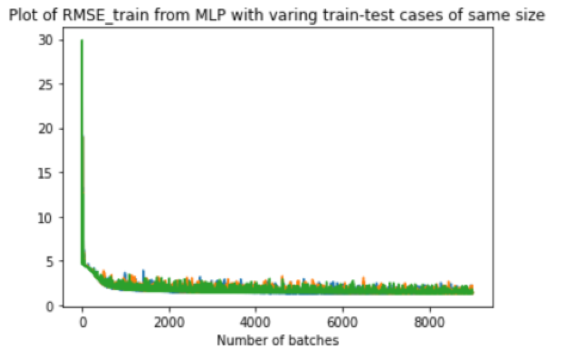

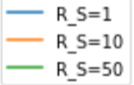

Random State = 1: MREPtrain = 0.013, MREPtest=0.016

Random State = 10: MREPtrain = 0.013, MREPtest=0.013

Random State = 50: MREPtrain =0.014, MREPtest=0.014

computation time = 41.11 minutes

Changing the training and test cases for MLP training did not help much in improving RMSE and MREP as we can see from the RMSE graph and the MREP values for train and test. However it is notable that chosing a random state of 10 when splitting our data into train and test sets gave the same results for MREP in both train and test. This is good because it shows that our MLP predictor has done so well in the generalization of our data and will most likely produce the same accuracy or error of prediction for new cases unseen. This is also great because it means our main focus now will be to lower or error of prediction by tuning with other parameters. It can also be noted that the computation time used for tuning this single parameter is really high at 41.11 minutes. This could be a hindrance in making much progress in tuning other paramters or even just making adjustments to this specific tuning such as plotting without making errors on the first try. 

In [0]:
start = time.process_time()
k=[3,5,9]

def mlp_out(k):
  #randomly split set of predcases into train and test
  x_train1, x_test1, y_train1, y_test1 = train_test_sp
  lit(Vt, Y, test_size=0.1, random_state=1)

  #begin building of mlp to extract weights
  os.environ['PYTHONHASHSEED']=str(1)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # new flag present in tf 2.0+
  np.random.seed(123)
  tf.random.set_seed(123)
  ops.reset_default_graph()
  mlp = Sequential()
  mlp.add(Dense(k, activation='relu', input_dim=18, bias_initializer=Constant(value=5)))
  mlp.add(Dense(1, activation='relu', bias_initializer=Constant(value=5)))
  mlp.summary()

  #reshape dataframes
  x_train1=pd.DataFrame(x_train1).values.reshape(888,18)
  x_test1=pd.DataFrame(x_test1).values.reshape(99,18)
  y_train1=pd.DataFrame(y_train1).values.reshape(888,1)
  y_test1=pd.DataFrame(y_test1).values.reshape(99,1)

  # configure suitable lr and decay
  mlp.compile(optimizer=optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99, amsgrad=False), loss='mean_squared_error')
  #mlp.compile(optimizer=optimizers.SGD(learning_rate=0.01, decay=1e-7), loss='mean_squared_error')
  class mlpMyHistory(callbacks.Callback):
      def on_train_begin(self, logs={}):
        self.MSEtrain1 = []
        self.MSEtest1 = []
      def on_batch_end(self, batch, logs={}):
        self.MSEtrain1.append(self.model.evaluate(x_train1,y_train1,verbose = 0))
        self.MSEtest1.append(self.model.evaluate(x_test1,y_test1,verbose = 0))

  mlpMyMonitor1 = mlpMyHistory()

  es1 = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200, restore_best_weights=True)
  mlpMonitor1 = mlp.fit(x_train1, y_train1, epochs=1000, batch_size=100, callbacks = [mlpMyMonitor1, es1], validation_data = (x_test1, y_test1), verbose = 2)
  z_train1=mlp.predict(x_train1)
  z_test1=mlp.predict(x_test1)
  MREPtrain1=np.average(abs(z_train1-y_train1)/y_train1)
  MREPtest1=np.average(abs(z_test1-y_test1)/y_test1)
  MSE_train1=mlpMyMonitor1.MSEtrain1
  
  return MSE_train1, MREPtrain1, MREPtest1

%matplotlib inline
plt.figure(figsize=(8, 5))
plt.figure(8)
labels3=['k=3','k=5','k=9']
for k in k:
  MSE_train1, MREPtrain1, MREPtest1 = mlp_out(k)
  plt.plot(np.sqrt(MSE_train1))
  print('k=', k,'MREPtrain:',round(MREPtrain1,3))
  print('MREPtest:',round(MREPtest1,3))
plt.xlabel('Number of batches')
plt.legend(labels3)
plt.title('Plot of RMSE_train from MLP with varying dim(k)')
plt.show()
comp_time=time.process_time() - start
print('Computation time for MLP training:',round(comp_time,2),'seconds')


2) Using varying values of dim(k) to determine number of hidden layers and their performance result

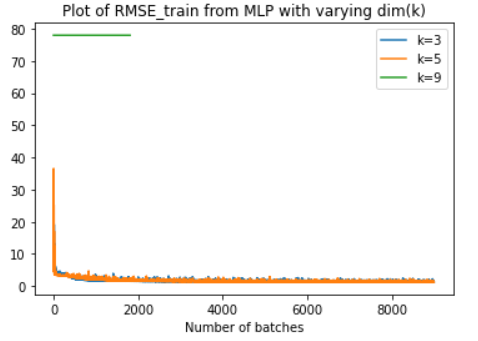

Dimension of K:

k=3: MREPtrain= 0.013, MREPtest= 0.016, # Parameters= 61

k=5: MREPtrain= 0.013, MREPtest= 0.016, # Parameters= 101

k=9: MREPtrain= 1.0, MREPtest= 1.0, # Parameters= 181

Computation time = 31.03 minutes

Varing the dimension of k did not do much good other than show that higher dimensions of k may be a bad choice. As we can see on the graph, dimensions = 3 and 5 gave the exact same results but when a higher dimension 9 was used, our RMSE produced horrible results and early stopping was applied very early on. In this case, we can say that a lower dimension is preferred as the number of parameters is lower, meaning a higher robustness ratio. 


3) Using varying seed values for random initialization of weights and biases

In [0]:
start = time.process_time()
seed=[1.5,12.3,123]
def mlp_out(size):
  #randomly split set of predcases into train and test
  x_train1, x_test1, y_train1, y_test1 = train_test_split(Vt, Y, test_size=0.1, random_state=1)

  #begin building of mlp to extract weights
  os.environ['PYTHONHASHSEED']=str(1)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # new flag present in tf 2.0+
  np.random.seed(123)
  tf.random.set_seed(seed)
  ops.reset_default_graph()
  mlp = Sequential()
  mlp.add(Dense(3, activation='relu', input_dim=18, bias_initializer=Constant(value=5)))
  mlp.add(Dense(1, activation='relu', bias_initializer=Constant(value=5)))
  mlp.summary()

  #reshape dataframes
  x_train1=pd.DataFrame(x_train1).values.reshape(888,18)
  x_test1=pd.DataFrame(x_test1).values.reshape(99,18)
  y_train1=pd.DataFrame(y_train1).values.reshape(888,1)
  y_test1=pd.DataFrame(y_test1).values.reshape(99,1)

  # configure suitable lr and decay
  mlp.compile(optimizer=optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99, amsgrad=False), loss='mean_squared_error')
  #mlp.compile(optimizer=optimizers.SGD(learning_rate=0.01, decay=1e-7), loss='mean_squared_error')
  class mlpMyHistory(callbacks.Callback):
      def on_train_begin(self, logs={}):
        self.MSEtrain1 = []
        self.MSEtest1 = []
      def on_batch_end(self, batch, logs={}):
        self.MSEtrain1.append(self.model.evaluate(x_train1,y_train1,verbose = 0))
        self.MSEtest1.append(self.model.evaluate(x_test1,y_test1,verbose = 0))

  mlpMyMonitor1 = mlpMyHistory()

  es1 = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200, restore_best_weights=True)
  mlpMonitor1 = mlp.fit(x_train1, y_train1, epochs=1000, batch_size=100, callbacks = [mlpMyMonitor1, es1], validation_data = (x_test1, y_test1), verbose = 2)
  z_train1=mlp.predict(x_train1)
  z_test1=mlp.predict(x_test1)
  MREPtrain1=np.average(abs(z_train1-y_train1)/y_train1)
  MREPtest1=np.average(abs(z_test1-y_test1)/y_test1)
  MSE_train1=mlpMyMonitor1.MSEtrain1
  
  return MSE_train1, MREPtrain1, MREPtest1

%matplotlib inline
plt.figure(figsize=(8, 5))
plt.figure(8)
labels3=['init=1.5','init=12.3','init=100']
for seed in seed:
  MSE_train1, MREPtrain1, MREPtest1 = mlp_out(size)
  plt.plot(np.sqrt(MSE_train1))
  print('init=', seed,'MREPtrain:',round(MREPtrain1,3))
  print('MREPtest:',round(MREPtest1,3))
plt.xlabel('Number of batches')
plt.legend(labels3)
plt.title('Plot of RMSE_train from MLP with varying initialization of weights')
plt.show()
comp_time=time.process_time() - start
print('Computation time for MLP training:',round(comp_time,2),'seconds')


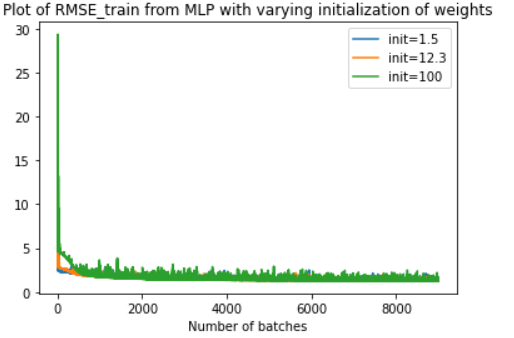

Random Initialization of weights and biases:

init # = 1.5: MREPtrain= 0.014, MREPtest= 0.017

init # = 12.3: MREPtrain= 0.013, MREPtest= 0.017

init # = 123: MREPtrain= 0.013, MREPtest= 0.016

Computation time: 35.15 minutes

Tuning the initialization of weights and biases was not very helpful. Instead, the values used performed worse than the original which was set to be init # = 123. Perhaps higher values would have performed better.

Although we failed in our efforts to find the the optimal parameters to reduce MREP results for both train and test, there are several other tuning options that could be used to improve accuracy, such as learning rate, beta_1 and beta_2 from Adam Optimizer, # epochs, batch size. The optimal set of hyperparameters can be found using a 'GridSearch' model which trains our model using several sets of hyperparametrs and outputs the best or optimal set of hyperparamters. Although this may be the best way to do it, the computation time will be very long and it will be an aggressive process if the computer device being used is not able to withstand this. The computation time will most likely be in hours. 

This MLP training process has been rewarding however as we have been able to see what set of hyperparameters will make the model work, and what sets will produce good error of prediction of stock prices for the stock market S&P 500